# becquerel fitting example

In [1]:
import becquerel as bq
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

%load_ext autoreload
%autoreload 2

np.random.seed(0)

Read an example spectrum into a Spectrum object

In [2]:
spec1 = bq.Spectrum.from_file('../tests/samples/digibase_5min_30_1.spe')

SpeFile: Reading file ../tests/samples/digibase_5min_30_1.spe


/Users/jvavrek/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jvavrek/becquerel/becquerel/parsers/spectrum_file.py:137: SpectrumFileParsingWarning: Spectrum will be initated without an energy calibration;invalid calibration, energies not monotonically increasing.
  warnings.warn(


Plot the entire spectrum and the ROI we want to fit

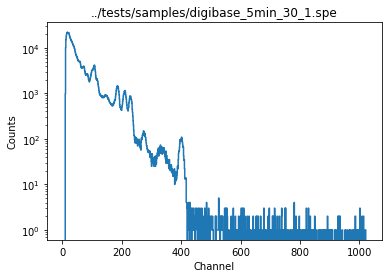

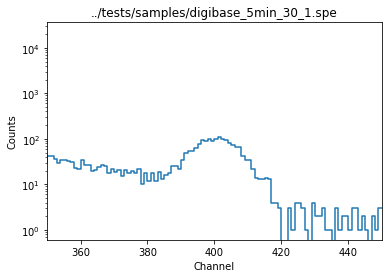

In [3]:
spec1.plot(yscale='log')
plt.show()

spec1.plot(yscale='log', xlim=(350, 450))
plt.show()

Let's first try a Gaussian peak shape and a simple linear background

In [4]:
model = (bq.fitting.GaussModel(prefix='gauss0_') + bq.fitting.LineModel(prefix='linear_'))

/Users/jvavrek/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pass our model and data to a Fitter object, then perform the fit

In [5]:
fitter = bq.Fitter(
    model,
    x=spec1.bin_indices,
    y=spec1.counts_vals,
    y_unc=spec1.counts_uncs,
    roi=(350, 450)
)

fitter.fit()

`custom_plot()` lets us see the fit result and diagnostics simultaneously

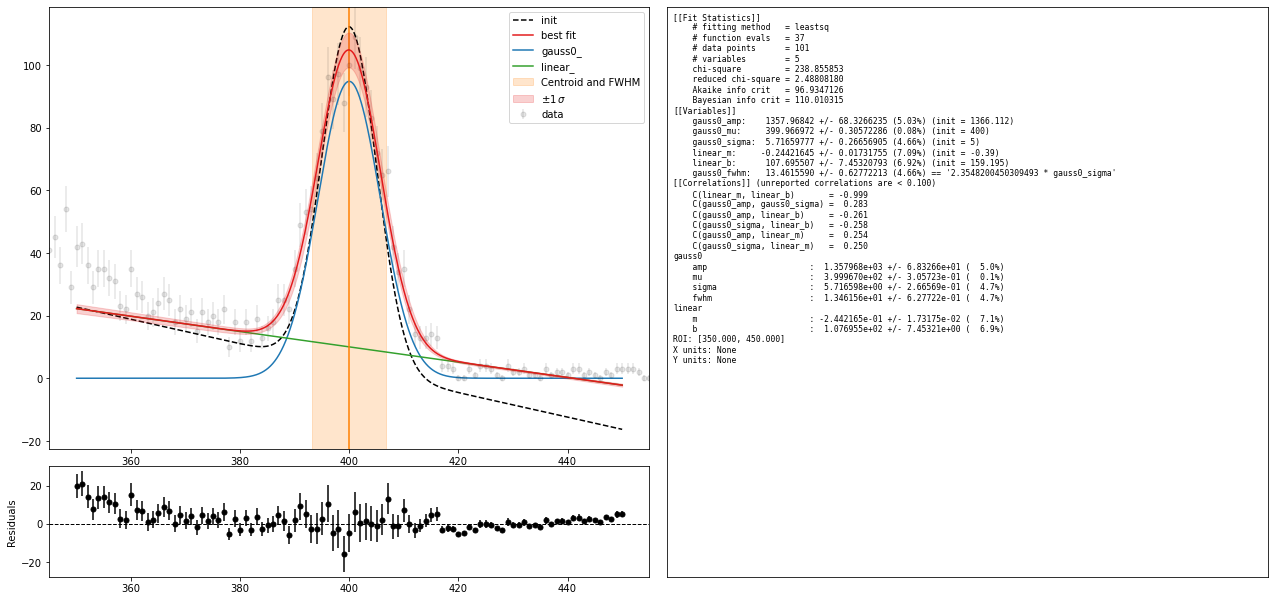

In [6]:
fitter.custom_plot()
plt.show()

It looks like there's still a trend in the residuals. Let's try an exponential background model instead of linear.
Note we can pass a list of string model names to the Fitter.

In [7]:
fitter = bq.Fitter(
    ['gauss', 'exp'],
    x=spec1.bin_indices,
    y=spec1.counts_vals,
    y_unc=spec1.counts_uncs,
    roi=(350, 450)
)
fitter.fit(backend='lmfit')

/Users/jvavrek/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can also specify that we want to plot residuals relative to the bin error (`residual_type=sigma`) or relative to the model (`residual_type=rel`) instead of absolute residuals (`residual_type=abs`, default).

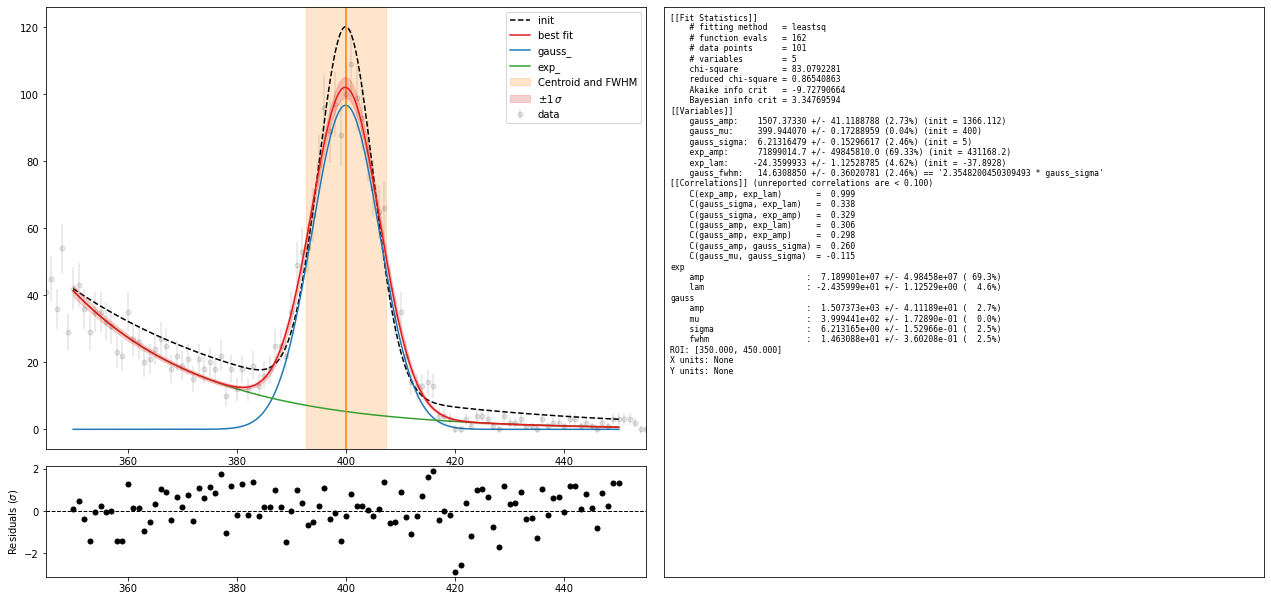

In [8]:
fitter.custom_plot(residual_type='sigma')
plt.show()

The normalized residuals help show that the exponential model fits fairly well---nearly all residuals are within $\pm2\sigma$, and there is no obvious trend.

We can also use the `iminuit` package to perform Poisson-loss fitting and also get uncertainties, a feature `lmfit` currently does not support.

In [9]:
fitter.fit(backend='minuit-pml')

/Users/jvavrek/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


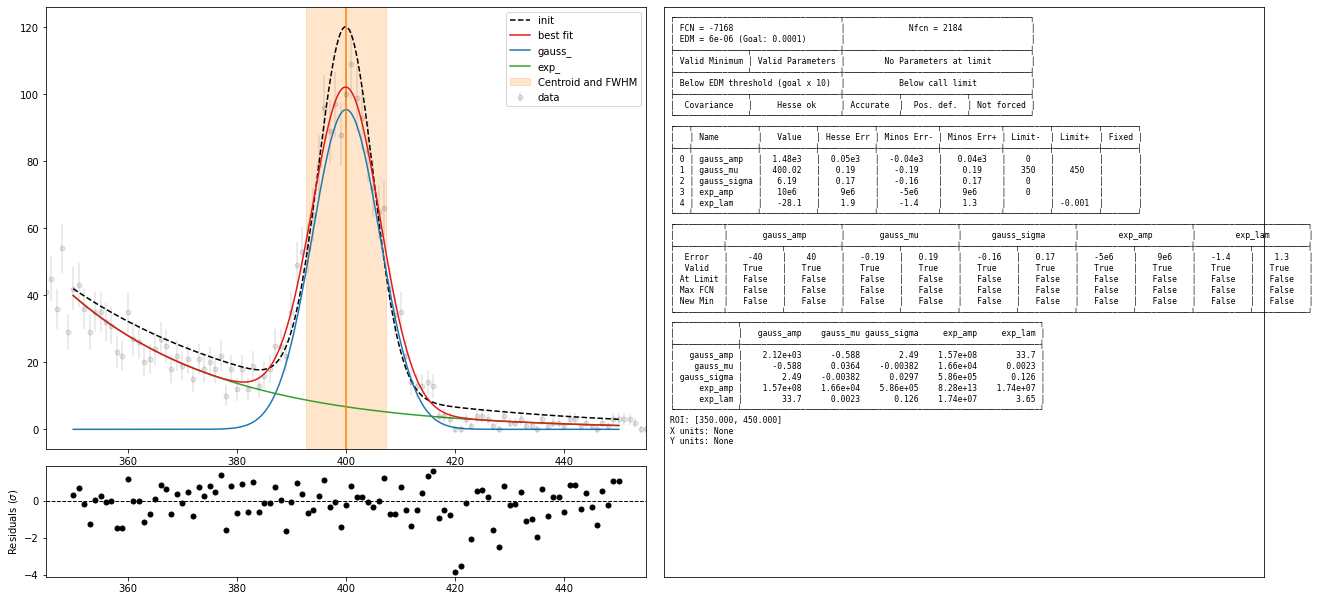

In [10]:
fitter.custom_plot(residual_type='sigma')
plt.show()

A better way to look at the `minuit` stats is with `fitter.result`. We can see that the fit parameters are valid, as are the error estimates.

In [11]:
fitter.result

/Users/jvavrek/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -7168                      │             Nfcn = 2184              │
│ EDM = 6e-06 (Goal: 0.0001)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name        │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ gauss_amp   │  1.48e3   │  0.05e3   │  -0.04e3   │   0.04e3   │    0    │         │       │
│ 1 │ gauss_mu    │  400.02   │   0.19    │   -0.19    │    0.19    │   350   │   450   │       │
│ 2 │ gauss_sigma │   6.19    │   0.17    │   -0.16    │    0.17    │    0    │         │       │
│ 3 │ exp_amp     │   10e6    │    9e6    │    -5e6    │    9e6     │    0    │         │       │
│ 4 │ exp_lam     │   -28.1   │    1.9    │    -1.4    │    1.3     │         │ -0.001  │       │
└───┴─────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │       gauss_amp       │       gauss_mu        │      gauss_sigma      │        exp_amp        │        exp_lam        │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -40    │    40     │   -0.19   │   0.19    │   -0.16   │   0.17    │   -5e6    │    9e6    │   -1.4    │    1.3    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌─────────────┬─────────────────────────────────────────────────────────────┐
│             │   gauss_amp    gauss_mu gauss_sigma     exp_amp     exp_lam │
├─────────────┼─────────────────────────────────────────────────────────────┤
│   gauss_amp │    2.12e+03      -0.588        2.49    1.57e+08        33.7 │
│    gauss_mu │      -0.588      0.0364    -0.00382    1.66e+04      0.0023 │
│ gauss_sigma │        2.49    -0.00382      0.0297    5.86e+05       0.126 │
│     exp_amp │    1.57e+08    1.66e+04    5.86e+05    8.28e+13    1.74e+07 │
│     exp_lam │        33.7      0.0023       0.126    1.74e+07        3.65 │
└─────────────┴─────────────────────────────────────────────────────────────┘